# Finetune ResNet50


With 1000 x 400 melspectrogram images (resized and padded) without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:

FINETUNED_MODEL = 'resnet50_resizepad'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Import ResizePad


In [14]:
from transforms.ResizePad import ResizePad

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    ResizePad(size=(224, 224)),  # Maintain aspect ratio then pad
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

C:\Users\profi\AppData\Local\Temp\ipykernel_14436\1412711753.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.55it/s, Loss=1.3915354013442993, Elapsed=20.7788s, ETA=0.0000s] 


Epoch 1 completed in 75.6945s
Train Loss: 1.5196346637141498 - Train Accuracy: 37.9706474299541
Validation Loss: 1.387647687594096 - Validation Accuracy: 40.956099620092864

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.17203950881958, Elapsed=20.5971s, ETA=0.0000s]   


Epoch 2 completed in 73.5858s
Train Loss: 1.3449120290706613 - Train Accuracy: 43.393410370638385
Validation Loss: 1.368284641901652 - Validation Accuracy: 41.93752638243985

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.72it/s, Loss=0.9776222705841064, Elapsed=20.6855s, ETA=0.0000s] 


Epoch 3 completed in 73.5324s
Train Loss: 1.2960688981706696 - Train Accuracy: 45.19572148978992
Validation Loss: 1.3437757722536723 - Validation Accuracy: 43.341072182355425

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.1931520700454712, Elapsed=20.5323s, ETA=0.0000s] 


Epoch 4 completed in 73.3322s
Train Loss: 1.2627666844108891 - Train Accuracy: 46.18167838809615
Validation Loss: 1.275689529577891 - Validation Accuracy: 46.03208104685521

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.0958094596862793, Elapsed=20.5475s, ETA=0.0000s] 


Epoch 5 completed in 73.4135s
Train Loss: 1.2467995058594412 - Train Accuracy: 46.85556635987427
Validation Loss: 1.3039197365442912 - Validation Accuracy: 43.80540312368088

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.1626285314559937, Elapsed=20.5798s, ETA=0.0000s] 


Epoch 6 completed in 73.2845s
Train Loss: 1.2338594823558895 - Train Accuracy: 47.56563623617738
Validation Loss: 1.2451141635576883 - Validation Accuracy: 47.09793161671592

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=0.9348137378692627, Elapsed=20.7414s, ETA=0.0000s] 


Epoch 7 completed in 73.5694s
Train Loss: 1.2169188161116804 - Train Accuracy: 48.00208045951019
Validation Loss: 1.300928185780843 - Validation Accuracy: 46.44364710848459

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=0.890986442565918, Elapsed=20.4869s, ETA=0.0000s]  


Epoch 8 completed in 73.4113s
Train Loss: 1.210258737292593 - Train Accuracy: 48.37068361185862
Validation Loss: 1.2524569646517436 - Validation Accuracy: 45.821021528070915

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.0023103952407837, Elapsed=20.5307s, ETA=0.0000s] 


Epoch 9 completed in 73.3988s
Train Loss: 1.195691147636127 - Train Accuracy: 48.782252775830486
Validation Loss: 1.2525806188583375 - Validation Accuracy: 44.71295905445336

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.1402854919433594, Elapsed=20.4257s, ETA=0.0000s] 


Epoch 10 completed in 73.3824s
Train Loss: 1.1914097029349708 - Train Accuracy: 49.110151285588294
Validation Loss: 1.2316582854588827 - Validation Accuracy: 46.90797804981005

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=0.9432259202003479, Elapsed=20.5756s, ETA=0.0000s] 


Epoch 11 completed in 73.3031s
Train Loss: 1.1848953221574685 - Train Accuracy: 49.27975396304923
Validation Loss: 1.2847997188568114 - Validation Accuracy: 44.61798227100042

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s, Loss=1.2259068489074707, Elapsed=20.6599s, ETA=0.0000s] 


Epoch 12 completed in 73.9658s
Train Loss: 1.1733273069638048 - Train Accuracy: 49.603129734741415
Validation Loss: 1.216417240301768 - Validation Accuracy: 49.67285774588434

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s, Loss=1.115498423576355, Elapsed=20.5459s, ETA=0.0000s]  


Epoch 13 completed in 73.9487s
Train Loss: 1.1659921781520624 - Train Accuracy: 49.85866443544922
Validation Loss: 1.243136469523112 - Validation Accuracy: 47.05571971295905

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.67it/s, Loss=0.9934408068656921, Elapsed=20.5852s, ETA=0.0000s] 


Epoch 14 completed in 73.9245s
Train Loss: 1.1621615406061183 - Train Accuracy: 50.20239252843671
Validation Loss: 1.2253910319010417 - Validation Accuracy: 48.6492190797805

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.59it/s, Loss=0.9861043095588684, Elapsed=20.8396s, ETA=0.0000s] 


Epoch 15 completed in 74.1113s
Train Loss: 1.1507646927254738 - Train Accuracy: 50.4534044910789
Validation Loss: 1.1918753838539125 - Validation Accuracy: 48.94470240607852

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.74it/s, Loss=0.9976162910461426, Elapsed=20.6037s, ETA=0.0000s] 


Epoch 16 completed in 73.8861s
Train Loss: 1.1505637155102857 - Train Accuracy: 50.310938242011716
Validation Loss: 1.2053248763084412 - Validation Accuracy: 50.042211903756865

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=0.9406626224517822, Elapsed=20.7478s, ETA=0.0000s] 


Epoch 17 completed in 74.1609s
Train Loss: 1.1421362213316681 - Train Accuracy: 50.95995115442889
Validation Loss: 1.1938919099171956 - Validation Accuracy: 48.92359645420009

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.64it/s, Loss=1.2736870050430298, Elapsed=20.7069s, ETA=0.0000s] 


Epoch 18 completed in 73.9612s
Train Loss: 1.1313598676223975 - Train Accuracy: 51.22679270030076
Validation Loss: 1.201482986609141 - Validation Accuracy: 52.089489235964535

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.68it/s, Loss=1.1120703220367432, Elapsed=20.7229s, ETA=0.0000s] 


Epoch 19 completed in 74.3416s
Train Loss: 1.1251876995053594 - Train Accuracy: 51.27428144998982
Validation Loss: 1.2120640103022258 - Validation Accuracy: 51.40354579991558

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=1.2758241891860962, Elapsed=20.7827s, ETA=0.0000s] 


Epoch 20 completed in 74.4066s
Train Loss: 1.1246896882277693 - Train Accuracy: 51.55016847199294
Validation Loss: 1.2195836273829141 - Validation Accuracy: 51.23469818488814

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.0586141347885132, Elapsed=20.2255s, ETA=0.0000s] 


Epoch 21 completed in 73.3484s
Train Loss: 1.1222474087524965 - Train Accuracy: 51.507202460369506
Validation Loss: 1.1936739834149679 - Validation Accuracy: 50.970873786407765

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.93it/s, Loss=0.931796669960022, Elapsed=19.8786s, ETA=0.0000s]  


Epoch 22 completed in 72.1850s
Train Loss: 1.1143002487675993 - Train Accuracy: 51.7604757920445
Validation Loss: 1.180027596950531 - Validation Accuracy: 48.29041789784719

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.86it/s, Loss=1.192354440689087, Elapsed=20.1031s, ETA=0.0000s]  


Epoch 23 completed in 72.5388s
Train Loss: 1.1167729521073357 - Train Accuracy: 51.819271386897626
Validation Loss: 1.2122936622301737 - Validation Accuracy: 52.33220768256648

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.88it/s, Loss=1.1963173151016235, Elapsed=19.9350s, ETA=0.0000s] 


Epoch 24 completed in 72.8170s
Train Loss: 1.1084621936255108 - Train Accuracy: 52.1426471585898
Validation Loss: 1.1864970485369364 - Validation Accuracy: 51.340227944280294

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.0419189929962158, Elapsed=20.0161s, ETA=0.0000s] 

Epoch 25 completed in 72.5363s
Train Loss: 1.0970975396605585 - Train Accuracy: 52.30772709798512
Validation Loss: 1.1725841252009075 - Validation Accuracy: 50.41156606162937



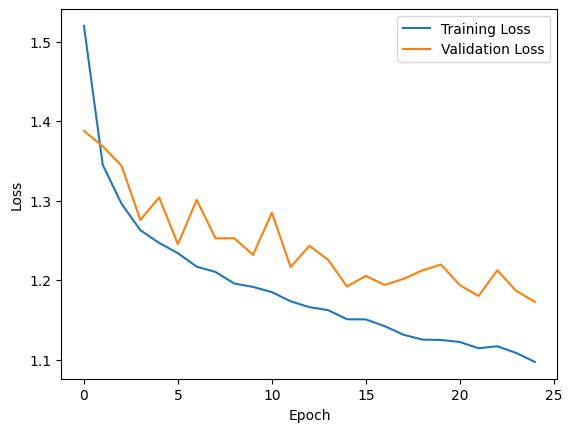

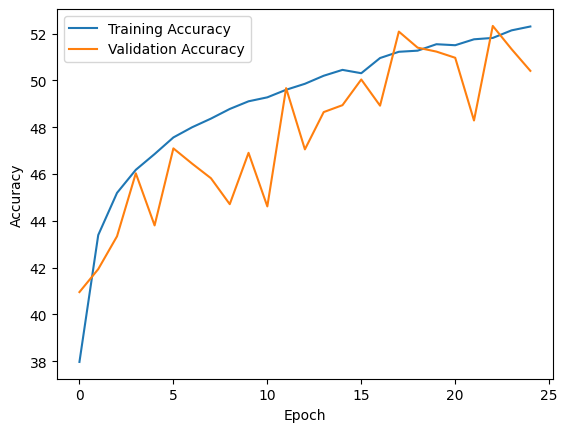

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_14436\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:20<00:00,  3.59it/s]


Test Results (Best Model):
Test Loss: 1.2044
Test Accuracy: 51.40%


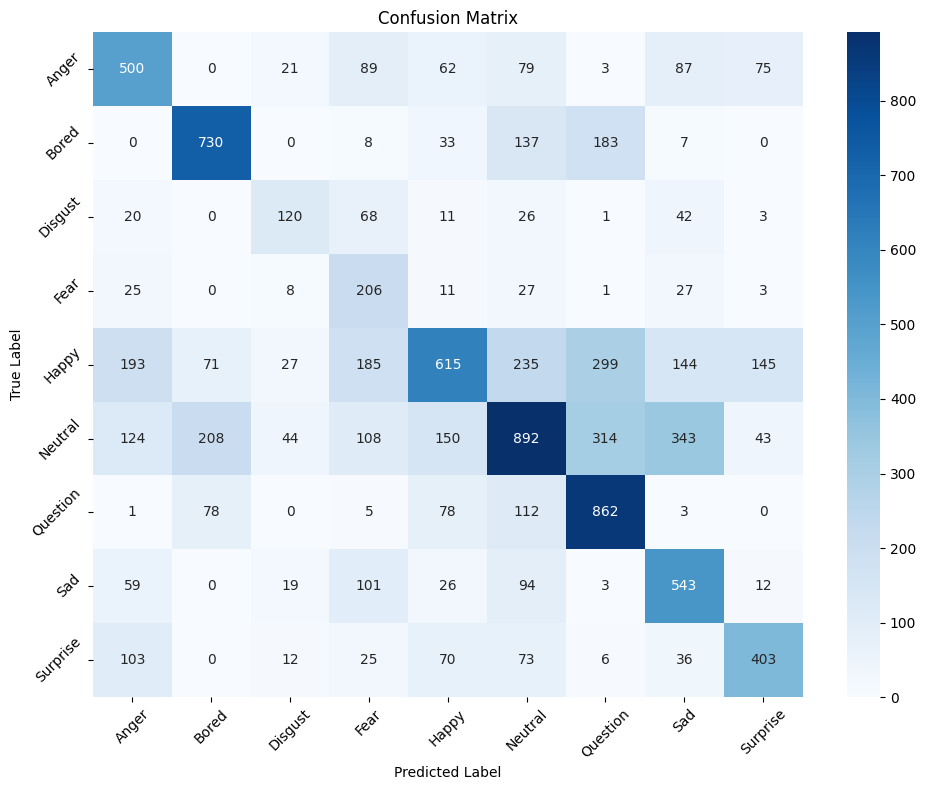

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)